In [ ]:
!pip install python_speech_features

In [2]:
#Import libraries and packages
import os
import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
import pickle
import librosa
import keras.metrics
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import ModelCheckpoint
import shutil
import IPython.display as ipd
import librosa.display

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,roc_auc_score
from keras.callbacks import EarlyStopping
from keras.models import load_model
import time

Using TensorFlow backend.


In [4]:

# instruction:
#1.only need to change the data_dir; put the labels.csv under the data_dir before running code; 
#2.create a folder namely audio and put all audio data there
#data directory

#data_dir= '/scratch1/tuyenl/Dataset_05_mixed_trimmed_scream_on_grader_-15db/' 
data_dir= '../../Datasets/Dataset_05_screaming/scream_over_noise/6_scream_over_6equipment/snr_mixed_-30/merged_noisy_signal_and_noise/'
#data_dir= '../../Datasets/Dataset_05_screaming/scream_over_noise/temp/'

#data_dir= '/scratch1/tuyenl/Dataset_01_SC_rev3/'
#data_dir= '../../Datasets/Dataset_01_SC_rev3/'
label_file= data_dir+'labels.csv'
audio_dir =  data_dir+'audio/'

processed_dir = data_dir+'trained_model/' # this folder will be automatically created if not exist
if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)

# links to 'clean', 'models', and 'pickles' folders
clean_dir = processed_dir+'clean_audio/' # this folder will be automatically created if not exist to store resample audio data
if not os.path.exists(clean_dir):
    os.makedirs(clean_dir)
    
clean_test_dir = data_dir+'trained_model/clean_test/'# this folder will be automatically created if not exist
if not os.path.exists(clean_test_dir):
    os.makedirs(clean_test_dir)
    
models_dir = data_dir+'trained_model/models/'# this folder will be automatically created if not exist
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
pickles_dir = data_dir+'trained_model/pickles/'# this folder will be automatically created if not exist
if not os.path.exists(pickles_dir):
    os.makedirs(pickles_dir)
    
result_dir = data_dir+'evaluation_results/'# this folder will be automatically created if not exist
if not os.path.exists(result_dir):
    os.makedirs(result_dir)


In [1015]:
#do not run this section unless you want to reprocess the 
#cleaning existing pre-proceessed data files

#shutil.rmtree(pickles_dir) #clean folders
#os.mkdir(pickles_dir)

In [1016]:
#do not run this section unless you want to retrain the models
#shutil.rmtree(models_dir) #clean folders
#os.mkdir(models_dir)

In [5]:
# Choose the type of neural network "CNN" or "RNN"
mode = "CNN" # options: 'CNN' or 'RNN'

In [6]:
#run this whenever you need to train a new model for a new parameter set
#change the value of the parameters if needed
class Config:
    def __init__(self, mode=mode, nfilt=26, nfeat=13, nfft=512, rate=16000, winstep=0.01, winlen=0.025, samplelen=1):
        self.mode = mode
        self.hop_length = int((winlen-winstep)*rate)
        self.nfilt = nfilt
        self.nfeat = nfeat #number of mfcc values
        self.nfft = nfft #this must be greater than rate*winlen
        self.rate = rate
        self.winstep = winstep #window step, in s, this parameter used for calculating mfcc
        self.winlen = winlen #window length, in s, this shoudl be smaller than n_fft/rate, eg, with rate of 16k and nfft of 512, winlen must be less than 0.032
        self.samplelen = samplelen # length of each training sample in second, e.g.m a sample of a tenth second, these samples will be used as an input data of the neural network
        self.step = int(rate * samplelen) # this indicates the sample length in number of discrete wave points, e.g., rate = 16k and sample, step = 1600
        self.feature_type ="stft" # options 'mfcc' and 'stft'
        #self.model_path = os.path.join(models_dir, mode + '.model') #no need this
        #self.p_path = os.path.join(pickles_dir, mode + '.p')

In [7]:
#set/create a sub model under the models dir according to the config
def _set_model_folders (config,version_date):
    models_subdir = models_dir + str(config.mode)+ '_' + str(config.feature_type) + '_' + str(config.nfft)+'_'+ str(config.samplelen) +'_'+str(config.winstep) +'_'+str(config.winlen) +'/'+version_date+'/'
    pickles_subdir = pickles_dir + str(config.mode)+ '_'+ str(config.feature_type) + '_' + str(config.nfft)+'_'+ str(config.samplelen) +'_'+str(config.winstep) +'_'+str(config.winlen) +'/'+version_date+'/'
    p_path = os.path.join(pickles_subdir, mode + '.p') # path to save the model configuration
    if not os.path.exists(models_subdir):
        os.makedirs(models_subdir)
    if not os.path.exists(pickles_subdir):
        os.makedirs(pickles_subdir)  
    return models_subdir,pickles_subdir

In [8]:
#run this whenever you need to train a new model for a new parameter set
from datetime import date
today = date.today()
version_date = today.strftime("%d-%m-%Y")
#version_date = '14-11-2020'
config = Config(mode=mode)
models_subdir,pickles_subdir = _set_model_folders(config,version_date)

In [9]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False,
                             sharey=True, figsize=(15, 10))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(1):
        for y in range(3):
            axes[x, y].set_title(list(signals.keys())[i])
            axes[x, y].plot(list(signals.values())[i])
            axes[x, y].get_xaxis().set_visible(False)
            axes[x, y].get_yaxis().set_visible(False)
            i += 1

In [10]:
def plot_fft(fft):
    fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False,
                             sharey=True, figsize=(15, 10))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(1):
        for y in range(3):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x, y].set_title(list(fft.keys())[i])
            axes[x, y].plot(freq, Y)
            axes[x, y].get_xaxis().set_visible(False)
            axes[x, y].get_yaxis().set_visible(False)
            i += 1

In [11]:
def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False,
                             sharey=True, figsize=(15, 10))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(1):
        for y in range(3):
            axes[x, y].set_title(list(fbank.keys())[i])
            axes[x, y].imshow(list(fbank.values())[i],
                              cmap='hot', interpolation='nearest')
            axes[x, y].get_xaxis().set_visible(False)
            axes[x, y].get_yaxis().set_visible(False)
            i += 1

In [12]:
def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False,
                             sharey=True, figsize=(15, 10))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(1):
        for y in range(3):
            axes[x, y].set_title(list(mfccs.keys())[i])
            axes[x, y].imshow(list(mfccs.values())[i],
                              cmap='hot', interpolation='nearest')
            axes[x, y].get_xaxis().set_visible(False)
            axes[x, y].get_yaxis().set_visible(False)
            i += 1

In [13]:
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate*config.samplelen), min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return (mask)

In [14]:
def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1 / rate)
    Y = abs(np.fft.rfft(y) / n)
    return (Y, freq)

In [15]:
# Read the labels file
df = pd.read_csv(label_file)
df.set_index('fname', inplace=True)  # Set index column
for f in df.index:
    rate, signal = wavfile.read(audio_dir + f)  # Read the wav files
    df.at[f, 'length'] = signal.shape[0] / rate  # Compute the length of each file in seconds)

In [16]:
# retrieve the number of classes
noclass=len(list(set(df.label)))
classes = list(np.unique(df.label))  # types of classes of the data
#df_classes = DataFrame (classes,columns=['Class'])
arr_classes = np.array(classes)

pd.DataFrame(arr_classes).to_csv(data_dir+'classes.csv', index=None)

print("number of classes:"+ str(noclass))
print(arr_classes)

number of classes:2
['abnormal' 'normal']


label
abnormal    2499.850000
normal      3157.544722
Name: length, dtype: float64


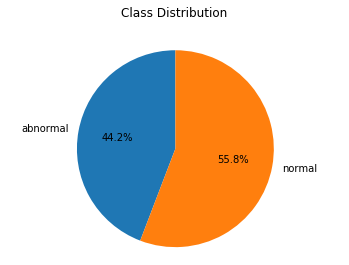

In [17]:
#data statistics
classes = list(np.unique(df.label))  # types of classes of the data
class_dist = df.groupby(['label'])['length'].sum()  # class distribution
print(class_dist)
# Plot class distribution piechart
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [18]:
# DO NOT run this unless you want to train on new data
#splitting data into train and test
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2,random_state=11)
train_df.to_csv(data_dir+'train.csv', index=True)
test_df.to_csv(data_dir+'test.csv', index=True)

In [57]:
#read train and test list from files
#run this when you want to train a new model using a new set of parameters on the same data

'''
train = pd.read_csv(data_dir+'train.csv')
train.set_index('fname', inplace=True)  # Set index column
test = pd.read_csv(data_dir+'test.csv') 
test.set_index('fname', inplace=True)  # Set index column

In [ ]:
# view test dataframe
'''
test

In [1041]:
#DO NOT run this unless you want to RE-DOWN SAMPLE the train data 
#down sample the data to 16k
shutil.rmtree(clean_dir) #clean folders
os.mkdir(clean_dir)
# “clean” directory stores the down-sampled audios
if len(os.listdir(clean_dir)) == 0:
    for f in tqdm(df.index):
        signal, rate = librosa.load(audio_dir + f, sr=16000)
        mask = envelope(signal, rate, 0.0005)
        wavfile.write(filename=clean_dir + f, rate=rate, data=signal[mask])

100%|██████████| 1060/1060 [05:39<00:00,  3.12it/s]


In [166]:
#do not run this section unless you want to process test data
# “clean” test audio directory, and store the down-sampled audios
#this is required for evaluation below

'''
shutil.rmtree(clean_test_dir) #clean folders
os.mkdir(clean_test_dir)
if len(os.listdir(clean_test_dir)) == 0:
    for f in tqdm(test.index):
        signal, rate = librosa.load(audio_dir + f, sr=16000) 
        mask = envelope(signal, rate, 0.0005)
        wavfile.write(filename=clean_test_dir + f, rate=rate, data=signal[mask])
        #print ('Completed cleaning test audio.')

100%|██████████| 60/60 [00:27<00:00,  2.21it/s]


In [38]:
# this module is to Show the ‘percentage’ path when the model loading data
#  not need this module
'''
def check_data():
    if os.path.isfile(p_path):
        print('Loading existing data for {} model'.format(config.mode))
        with open(p_path, 'rb') as handle:
            tmp = pickle.load(handle)
            return tmp
    else:
        return None

In [21]:
# this module is for Processing input data
# this code is segment-based classification, rather than frame-based classification, 
# the input vector is the mfcc for the whole segment, not individual frames
# feature extraction for every audio sample
'''
def build_rand_feat(data):
    

    #tmp = check_data()
    #if tmp: # not use this code, forcing the recalculation of data
    #    return tmp.data[0], tmp.data[1] 
        
    # Create variables for the input data
    X = []  # samples
    y = []  # labels
    _min, _max = float('inf'), -float('inf')
    
    # Compute the length of each file in seconds
    # compute the number of signal samples, this is dependent on the the sample length definded in the config and the total len of train data
    
    # Create samples of a tenth second
    # Randomly sample along the length of our audio files
    n_samples = int(data['length'].sum() / config.samplelen) # e.g., with a tenth second segmentation/samples, given the total length of 125s of all training audio files, no samples (training samples) will be 1250. 
    print(n_samples)
    
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p=prob_dist)
        file = np.random.choice(data[data.label == rand_class].index)
        rate, wav = wavfile.read(clean_dir + file)
        label = data.at[file, 'label']
        rand_index = np.random.randint(0, wav.shape[0] - config.step)
        sample = wav[rand_index:rand_index + config.step] #
        # Use MFCCs for the samples
        X_sample = mfcc(sample, rate,
                        numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft, winfunc=np.hamming, winstep = config.winstep, winlen=config.winlen)
        #shape of X_sample will be (~sample lenth/winstep,no mfcc features=nfeat), winstep default ==0.01, 
        #with a tenth second sample, and winstep of 0.01s (default), X_sample has shape [9,nfeat]
        #see an exact formula for computing the number for frames based on sample lenth, winlen and win overlap below
        #https://www.mathworks.com/help/signal/ref/stft.html
        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        X.append(X_sample)
        y.append(classes.index(label))
    config.min = _min
    config.max = _max
    X, y = np.array(X), np.array(y) #the shape of X will be (n_samples, shape[0] of X_sample, no mfcc feature = nfeat)
    X = (X - _min) / (_max - _min)

    print(X.shape)
    # Reshape X
    if config.mode == 'CNN':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode == 'RNN':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    y = to_categorical(y, num_classes=noclass)
    config.data = (X, y)

    with open(p_path, 'wb') as handle:
        pickle.dump(config, handle, protocol=2)

    return X, y


In [1075]:
METRICS = [keras.metrics.TruePositives(name='tp'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.TrueNegatives(name='tn'),
           keras.metrics.FalseNegatives(name='fn'),
           keras.metrics.BinaryAccuracy(name='binary_accuracy'),
           keras.metrics.CategoricalAccuracy(name="categorical_accuracy"),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc'), ]


In [1076]:
# Creating CNN model
def get_conv_model(input_shape,noclass):
    model = Sequential()  # Instantiate the model class
    # Add the layers
    model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1),
                     padding='same', input_shape=input_shape))
    #The ‘padding‘ value of ‘same‘ calculates and adds the padding required to the input image (or feature map)
    #to ensure that the output has the same shape as the input  or previous layer.
    #if not using "same", the size will be reduced to by (kernel size -1),e.g., by 2 if kernel size is (3,3)
    #https://machinelearningmastery.com/padding-and-stride-for-convolutional-neural-networks/

    model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1),
                     padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', strides=(1, 1),
                     padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', strides=(1, 1),
                     padding='same'))
    model.add(MaxPool2D(2, 2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(noclass, activation='softmax'))
    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    return model

In [1077]:
#Creating RNN model
def get_recurrent_model(input_shape,noclass):
    #shape of data for RNN is (n, time, feat)
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(16, activation='relu')))
    model.add(TimeDistributed(Dense(8, activation='relu')))
    model.add(Flatten())
    model.add(Dense(noclass, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    return model

In [ ]:
#ref: https://github.com/tuyenbk/urban_sound_classification/blob/master/audio.py
'''
def _concat_features(self, feature):
        """
        Whenever a self._extract_xxx() method is called in this class,
        this function concatenates to the self.features feature vector
        """
        self.features = np.hstack(
            [self.features, feature] if self.features is not None else feature
        )

def _extract_mfcc(self, n_mfcc=25):
    mfcc = librosa.feature.mfcc(self.y, sr=self.sr, n_mfcc=n_mfcc)

    mfcc_mean = mfcc.mean(axis=1).T
    mfcc_std = mfcc.std(axis=1).T
    mfcc_feature = np.hstack([mfcc_mean, mfcc_std])
    self._concat_features(mfcc_feature)

def _extract_spectral_contrast(self, n_bands=3):
    spec_con = librosa.feature.spectral_contrast(
        y=self.y, sr=self.sr, n_bands=n_bands
    )

    spec_con_mean = spec_con.mean(axis=1).T
    spec_con_std = spec_con.std(axis=1).T
    spec_con_feature = np.hstack([spec_con_mean, spec_con_std])
    self._concat_features(spec_con_feature)

def _extract_chroma_stft(self):
    stft = np.abs(librosa.stft(self.y))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=self.sr)
    chroma_mean = chroma_stft.mean(axis=1).T
    chroma_std = chroma_stft.std(axis=1).T
    chroma_feature = np.hstack([chroma_mean, chroma_std])
    self._concat_features(chroma_feature)

def extract_features(self, *feature_list, save_local=True):
    """
    Specify a list of features to extract, and a feature vector will be
    built for you for a given Audio sample.
    By default the extracted feature and class attributes will be saved in
    a local directory. This can be turned off with save_local=False.
    """
    extract_fn = dict(
        mfcc=self._extract_mfcc,
        spectral=self._extract_spectral_contrast,
        chroma=self._extract_chroma_stft,
    )

    for feature in feature_list:
        extract_fn[feature]()


In [1078]:
def _extract_feature(audio_dir,dataframe,config):
    # Create variables for the input data
    X = []  # samples
    Y = []  # labels
    
    classes = list(np.unique(dataframe.label))  # types of classes of the data
    print(classes)
    for fn in tqdm(dataframe.index):
        
        #read wavfile
        rate, wav = wavfile.read(os.path.join(audio_dir, fn))
        label = dataframe.at[fn, 'label']

        #divide the file into small segment and make prediction for each segment
        for i in range(0, wav.shape[0]-config.step, config.step): 
            sample = wav[i:i+config.step]
            if config.feature_type == 'mfcc': 
                x = mfcc(sample, rate, numcep=config.nfeat,
                     nfilt=config.nfilt, nfft=config.nfft, winfunc=np.hamming)
            elif config.feature_type =='stft': 
                #x = librosa.feature.melspectrogram(sample,n_mels=60)
                #x = np.abs(librosa.stft(sample, n_fft=config.nfft, hop_length=config.hop_length, win_length=int(config.winlen*config.rate), window='hamming'))
                stft = np.abs(librosa.stft(sample, n_fft=config.nfft, hop_length=config.hop_length, win_length=int(config.winlen*config.rate), window='hamming'))
                mel_spec = librosa.feature.melspectrogram(S=stft**2, sr=rate,n_mels=60)
                x = librosa.amplitude_to_db(mel_spec, ref=np.max) #convert power to db
                #x = librosa.amplitude_to_db(x, ref=np.max) #convert power to db
            #x = (x - config.min) / (config.max - config.min)
            X.append(x)
            Y.append(classes.index(label))
         
    X, Y = np.array(X), np.array(Y) #the shape of X will be (n_samples, shape[0] of X_sample, no mfcc feature = nfeat)
    Y = to_categorical(Y, num_classes=noclass)
    
    if config.mode == 'CNN':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode == 'RNN':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    return X, Y

In [1079]:
def _initiate_model(mode,feature_matrix_shape,noclass):
    f_shape = feature_matrix_shape
    if config.mode == 'CNN':
        input_shape = (f_shape[1], f_shape[2], 1)
        model = get_conv_model(input_shape,noclass)

    elif config.mode == 'RNN':
        #X, y = build_rand_feat()
        #y_flat = np.argmax(y, axis = 1)
        input_shape = (f_shape[1], f_shape[2])
        model = get_recurrent_model(input_shape,noclass)
    return model

In [1080]:
# list all data in history
def _show_accuracy_history(history,save_path) :
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    if save_path != '':
        plt.savefig(save_path)
    plt.show()

In [1081]:
# summarize history for loss
def _show_loss_history(history,save_path):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    if save_path != '':
        plt.savefig(save_path)
    plt.show()
   

In [1082]:
#plot roc curve
def plot_roc_curve(model,X_test,save_path): 
    y_pre_prob=model.predict_proba(X_test)
    #print(y_pre_prob)

    #compute auc score, AUC: Area Under the ROC Curve
    auc_score=roc_auc_score(y_test,y_pre_prob)
    print('AUC Score:' + str(auc_score))

    #calcualte false positive and true positive rate, tpr is a synonym for recall.
    fpr , tpr , thresholds = roc_curve (y_test[:,0], y_pre_prob[:,0]) #[:,0] indicate the first class, use 1 to indicate the second class

    #make a plot
    plt.title('ROC Curve - Anomaly Detection')
    plt.plot(fpr,tpr) 
    plt.axis([0,1,0,1]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    if save_path != '':
        plt.savefig(save_path)
    plt.show()  
    

In [1083]:
# Create model and Create variables for the input data

#extract input features
#X, y = build_rand_feat(train) # FEATURE EXTRACTION STAGE
X,y = _extract_feature(clean_dir,df,config)
y_flat = np.argmax(y, axis=1)


class_weight = compute_class_weight('balanced',
                                    np.unique(y_flat),
                                    y_flat)

#get the DDN architecture, based on the config.mode
model = _initiate_model(mode,X.shape,noclass)
model.summary()

print('Input Shape'+str(X.shape))

#how to calculate the parameter of a cnn layer
#input has l=1 feature maps, k=16 feature maps as outputs,  filter size is n=3 and m=3.
#the total number of parameters are “(n*m*l+1)*k” = (3*3*1+1)*16 = 160; another example, (3*3*16+1)*32 = 4640
#ref: https://medium.com/@iamvarman/how-to-calculate-the-number-of-parameters-in-the-cnn-5bd55364d7ca#:~:text=And%20as%20an%20output%20from,l%2B1)*k%E2%80%9D.

  0%|          | 3/1060 [00:00<00:37, 28.03it/s]

['abnormal', 'normal']


100%|██████████| 1060/1060 [00:08<00:00, 121.82it/s]


Model: "sequential_236"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_941 (Conv2D)          (None, 60, 67, 16)        160       
_________________________________________________________________
conv2d_942 (Conv2D)          (None, 60, 67, 32)        4640      
_________________________________________________________________
conv2d_943 (Conv2D)          (None, 60, 67, 64)        18496     
_________________________________________________________________
conv2d_944 (Conv2D)          (None, 60, 67, 128)       73856     
_________________________________________________________________
max_pooling2d_236 (MaxPoolin (None, 30, 33, 128)       0         
_________________________________________________________________
dropout_236 (Dropout)        (None, 30, 33, 128)       0         
_________________________________________________________________
flatten_236 (Flatten)        (None, 126720)         

In [ ]:
# Fit model without kfold cross validation (optional)
# this is just for testing code, 
# training model needs cross validiation in the section below

#data splitting for single fold validation
#split data in stratify maner (default)
X_train_val, X_test, y_train_val, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)   
X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val, test_size = 0.1, random_state = 42) 
print(f'Train samples: {len(X_train)}; Validation samples: {len(X_val)} Test samples: {len(X_test)}')


#get the DDN architecture, based on the config.mode
model = _initiate_model(mode,X.shape,noclass)

model_path=os.path.join(models_subdir, 'model.model')
checkpoint = ModelCheckpoint(model_path, monitor='val_acc', verbose=1, mode='max',
                             save_best_only=True, save_weights_only=False, period=1) #only save the best model

#history=model.fit(X, y, epochs=100, batch_size=32,
#          shuffle=True, validation_split=0.2,
#          callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


history=model.fit(X_train, y_train, epochs=100, batch_size=32,
              shuffle=True,
            # We pass some validation for
            # monitoring validation loss and metrics
            # at the end of each epoch
            #validation_split=0.2,
            validation_data=(X_val, y_val),
            callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.001)])
# Save model
model.save(model_path)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


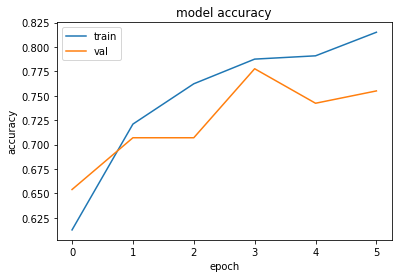

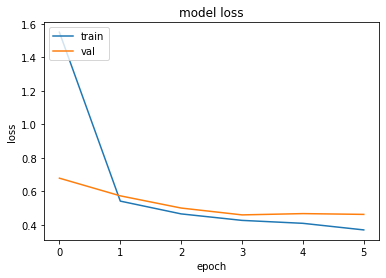

In [906]:
_show_accuracy_history(history,"")
_show_loss_history(history,"")

In [907]:
#show evaluation report
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score, precision_score, precision_recall_fscore_support

#X_test,y_test = _extract_feature(clean_test_dir,test,config)
#time starts to collect processing time

model_path=os.path.join(models_subdir, 'model.model')
model = load_model(model_path)

start_time = time.time()

y_pred = model.predict(X_test)

#time ends to collect processing time
print("Procesing time--- %s seconds ---" % (time.time() - start_time))

y_true=np.argmax(y_test, axis=1) 
y_pred=np.argmax(y_pred, axis=1) #perform an argmax() on the output vector to retrieve the index of the max probability across all labels. Read more about softmax function at https://towardsdatascience.com/the-softmax-function-neural-net-outputs-as-probabilities-and-ensemble-classifiers-9bd94d75932
    
# Generate generalization metrics
acc_score = accuracy_score(y_true, y_pred)*100
full_report = classification_report(y_true,y_pred)
short_report = precision_recall_fscore_support(y_true,y_pred)

#another way to extract evaluation accuracy
scores = model.evaluate(X_test, y_test, verbose=0)
print(f'Score: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

#print evaluation results
print('Accuracy:' + str(acc_score))
print(full_report)
print(short_report)

Procesing time--- 9.181344985961914 seconds ---
Score: loss of 0.40327888937911605; acc of 79.39394116401672%
Accuracy:79.39393939393939
              precision    recall  f1-score   support

           0       0.88      0.57      0.69       404
           1       0.76      0.95      0.84       586

    accuracy                           0.79       990
   macro avg       0.82      0.76      0.77       990
weighted avg       0.81      0.79      0.78       990

(array([0.88461538, 0.76164384]), array([0.56930693, 0.94880546]), array([0.69277108, 0.8449848 ]), array([404, 586]))


AUC Score:0.8084388185654008


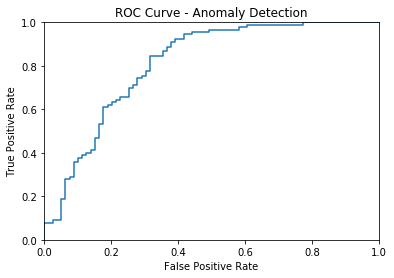

In [371]:
#show ROC curve
plot_roc_curve (model,X_test,"")

In [1084]:
#TRAIN with kfolder cross validation

#References: https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/#k-fold-cross-validation
#            https://www.machinecurve.com/index.php/2020/02/14/how-to-save-and-load-a-model-with-keras/



from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, average_precision_score, precision_recall_fscore_support, roc_curve,roc_auc_score



#from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold

# Define per-fold score containers
acc_per_fold = []
pre_per_fold = []
re_per_fold = []
f1_per_fold = []
report_per_fold = []
loss_per_fold = []
auc_per_fold = []
training_times =[]

num_folds = 10
cv = KFold(n_splits=num_folds, random_state = 32,shuffle=True) # shuffle should be true to ensure balance data, random state to fix random
cv.split(X)


#training parameters
batch_size=32
validate_split_ratio = 0.1
no_epochs = 0
training_type =''

#clean folder, deleted all old model
shutil.rmtree(models_subdir)
os.mkdir(models_subdir)

#results_file = result_dir + str(config.mode)+'_'+str(config.samplelen)+'_'+str(config.winstep)+'_'+str(config.winlen)+ '_' + version_date + '_predictions.csv'

fold_no = 1
for train_index, test_index in cv.split(X):
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    X_train_val, X_test = X[train_index], X[test_index]
    y_train_val, y_test = y[train_index], y[test_index]
    X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val, test_size = validate_split_ratio, random_state = 42) 

    print(f'Train samples: {len(X_train)}; Validation samples: {len(X_val)} Test samples: {len(X_test)}')
    
    model_path=os.path.join(models_subdir, 'fold' + str(fold_no)+ '.model')
    
    # checkpoint
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, mode='max',
                             save_best_only=True, save_weights_only=False, period=1)
    
    
    #get the DDN architecture, based on the config.mode
    model_per_fold = _initiate_model(mode,X.shape,noclass) 
        
    
    start_time = time.time()
    # Fit data to model
    #no_epochs=15
    #history_per_fold = model_per_fold.fit(X_train, y_train, batch_size=batch_size,
    #          epochs=no_epochs, callbacks=[checkpoint])
    
    
    # Type 1: Fit data to model, with early stoping (this is not recommeded for use in k-fold cross validation when data is limited)
    training_type = 'k-fold cross validation, early stoping, need to have validation split at: ' + str(validate_split_ratio)
    no_epochs=100
    history_per_fold = model_per_fold.fit(X_train, y_train, epochs=no_epochs, batch_size=batch_size,
                                          shuffle=True,
                                        # We pass some validation for
                                        # monitoring validation loss and metrics
                                        # at the end of each epoch
                                        #validation_split=0.2,
                                        validation_data=(X_val, y_val),
                                        callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001)])

    # Type 2: fit data to model, no early stoping (thus no need to have validation split)
    #no_epochs=15
    #training_type = 'k-fold cross validation, no early stoping, no need to have validation split, no epochs =' + str(no_epochs)
    #history_per_fold = model_per_fold.fit(X_train_val, y_train_val, batch_size=batch_size, epochs=no_epochs)
    
    training_times.append(time.time() - start_time)
    y_pred = model_per_fold.predict(X_test) #this variable is never used in this section
    
    
    y_pre_prob=model_per_fold.predict_proba(X_test)
    y_true=np.argmax(y_test, axis=1) 
    y_pred=np.argmax(y_pred, axis=1) 
    
    # Generate generalization metrics
    #acc_score = accuracy_score(y_true, y_pred)
    #pre_score = precision_score(y_true, y_pred)
    #rec_score=recall_score(y_true, y_pred)
    #f1=f1_score(y_true, y_pred)
    
    #acc_per_fold.append(acc_score * 100)
    #rec_per_fold.append(rec_score * 100)
    #pre_per_fold.append(pre_score * 100)
    #f1_per_fold.append(f1_score * 100)
    
    auc_per_fold.append(roc_auc_score(y_test,y_pre_prob)*100)
    report_per_fold.append(classification_report(y_true,y_pred))
    
    scores = model_per_fold.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model_per_fold.metrics_names[0]} of {scores[0]}; {model_per_fold.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0]*100)
   
    # Save model
    model_per_fold.save(model_path)
    
    # Increase fold number 
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Train samples: 4005; Validation samples: 446 Test samples: 495
Train on 4005 samples, validate on 446 samples
Epoch 1/100
4005/4005 [==============================] - 86s 21ms/step - loss: 2.1356 - acc: 0.5845 - val_loss: 0.6486 - val_acc: 0.5897
Epoch 2/100
4005/4005 [==============================] - 80s 20ms/step - loss: 0.6354 - acc: 0.6132 - val_loss: 0.6771 - val_acc: 0.5112
Epoch 3/100
4005/4005 [==============================] - 78s 19ms/step - loss: 0.5021 - acc: 0.7486 - val_loss: 0.3756 - val_acc: 0.8049
Epoch 4/100
4005/4005 [==============================] - 78s 20ms/step - loss: 0.3567 - acc: 0.8437 - val_loss: 0.3362 - val_acc: 0.8587
Epoch 5/100
4005/4005 [==============================] - 79s 20ms/step - loss: 0.3188 - acc: 0.8652 - val_loss: 0.3645 - val_acc: 0.8363
Epoch 6/100
4005/4005 [==============================] - 81s 20ms/step - loss: 0.3033 - acc: 0.8806 - val_lo

------------------------------------------------------------------------
> Data Directory: ../../Datasets/Dataset_05_screaming/scream_over_noise/6_scream_over_6equipment/snr_mixed_-10/merged_noisy_signal_and_noise/ 
 Total samples: 4946 
 k-fold cross validation, early stoping, need to have validation split at: 0.1 
 label
abnormal    2499.850000
normal      3157.544722
Name: length, dtype: float64
Score per fold
------------------------------------------------------------------------
> Fold 1 
 - Accuracy: 88.48484754562378 
 - AUC Score: 93.8800847457627 
 - Loss: 34.47503744878552 
 - Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.80      0.85       200
           1       0.87      0.94      0.91       295

    accuracy                           0.88       495
   macro avg       0.89      0.87      0.88       495
weighted avg       0.89      0.88      0.88       495
  %
--------------------------------------------------

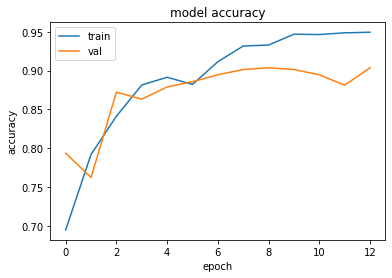

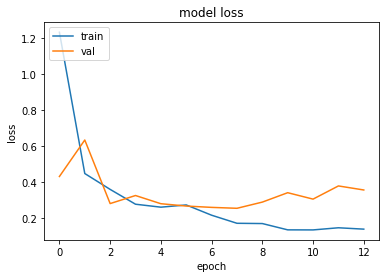

AUC Score:0.962198782265672


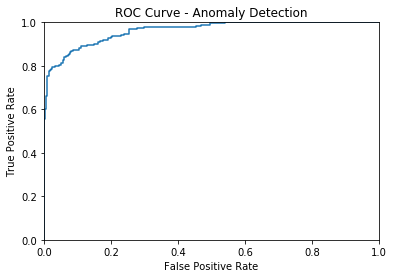

In [1085]:
#Print results and save k-fold evaluation results
# == Provide average scores ==
evaluation_file = open(result_dir + str(config.mode)+'_'+ str(config.feature_type)+ '_' + str(config.nfft) +'_'+str(config.samplelen)+'_'+str(config.winstep)+'_'+str(config.winlen)+'_'+version_date+'_evaluation_results.txt', "w")
sep_line='------------------------------------------------------------------------'
print(sep_line)
evaluation_file.write(sep_line+'\n')
rslt_line= f'> Data Directory: {data_dir} \n Total samples: {len(X)} \n {training_type} \n {class_dist}'
print(rslt_line)
evaluation_file.write(rslt_line+'\n')
rslt_line= 'Score per fold'
print(rslt_line)
evaluation_file.write(rslt_line+'\n')
for i in range(0, len(acc_per_fold)):
    print(sep_line)
    evaluation_file.write(sep_line+'\n')
    rslt_line = f'> Fold {i+1} \n - Accuracy: {acc_per_fold[i]} \n - AUC Score: {auc_per_fold[i]} \n - Loss: {loss_per_fold[i]} \n - Classification Report: \n {report_per_fold[i]}  %'
    print(rslt_line)
    evaluation_file.write(rslt_line+'\n')
print(sep_line)
evaluation_file.write(sep_line+'\n')
rslt_line = 'Average scores for all folds:'
print(rslt_line)
evaluation_file.write(rslt_line+'\n')
rslt_line =f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})'
print(rslt_line)
evaluation_file.write(rslt_line+'\n')
rslt_line = f'> Loss: {np.mean(loss_per_fold)} (+- {np.std(loss_per_fold)})'
print(rslt_line)
evaluation_file.write(rslt_line+'\n')
rslt_line = f'> AUC: {np.mean(auc_per_fold)} (+- {np.std(auc_per_fold)})'
print(rslt_line)
evaluation_file.write(rslt_line+'\n')
print(sep_line)
evaluation_file.write(sep_line+'\n')
rslt_line = f'> Training Time: {np.mean(training_times)} (+- {np.std(training_times)})'
print(rslt_line)
evaluation_file.write(rslt_line+'\n')
print(sep_line)
evaluation_file.write(sep_line+'\n')

evaluation_file.close()

#history record of last fold
accuracy_history_file = result_dir + str(config.mode)+'_'+ str(config.feature_type)+ '_' + str(config.nfft) +'_'+str(config.samplelen)+'_'+str(config.winstep)+'_'+str(config.winlen)+'_'+version_date+'_val_acc_history.png'
loss_history_file = result_dir + str(config.mode)+'_'+ str(config.feature_type)+ '_' + str(config.nfft) +'_'+str(config.samplelen)+'_'+str(config.winstep)+'_'+str(config.winlen)+'_'+version_date+'_val_loss_history.png'
_show_accuracy_history(history_per_fold,accuracy_history_file)
_show_loss_history(history_per_fold,loss_history_file)

#ROC chart
roc_chart_file = result_dir + str(config.mode)+'_'+ str(config.feature_type)+ '_' + str(config.nfft) +'_'+str(config.samplelen)+'_'+str(config.winstep)+'_'+str(config.winlen)+'_'+version_date+'_ROC chart.png'
plot_roc_curve(model_per_fold,X_test,roc_chart_file)

In [743]:
test_df

,label,length
fname,,
-15db_219657_K5_04_19.wav,abnormal,1.602
C3_07.wav,normal,6.000
-30db_336537_C3_09_234.wav,abnormal,4.000
-15db_316411_C3_08_233.wav,abnormal,1.150
-20db_104038_K2_04_8.wav,abnormal,6.932
...,...,...
-10db_399675_X1_08a_95.wav,abnormal,4.289
-30db_353285_X1_03_86.wav,abnormal,1.621
-5db_220822_X3_09b_124.wav,abnormal,0.751


In [744]:
test_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 212 entries, -15db_219657_K5_04_19.wav to -15db_YS_86_J1_10_131.wav
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   label   212 non-null    object 
 1   length  212 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.0+ KB


In [795]:
def _extract_samples(data_frame):
    col_names =  ['fname', 'wav', 'rate','label']
    sample_seg_df  = pd.DataFrame(columns = col_names)

    for fn in tqdm(data_frame.index):
        #read wavfile
        rate, wav = wavfile.read(os.path.join(clean_dir, fn))
        label = data_frame.at[fn, 'label']
        #divide the file into small segment and make prediction for each segment
        for i in range(0, wav.shape[0]-config.step, config.step): 
            sample = wav[i:i+config.step]
            seg_name = str(fn)[:-4]  +'_segment_' + str(i/rate) + ".wav"
            sample_seg_df.loc[len(sample_seg_df)] = [seg_name, sample, rate,label]
    return sample_seg_df

In [796]:
test_seg_df=_extract_samples(test_df)
test_seg_df.set_index('fname', inplace=True)  # Set index column

100%|██████████| 212/212 [00:03<00:00, 63.31it/s]


In [30]:
#do not run this section unless you want to process test data
# “clean” test audio directory, and store the down-sampled audios
#this is required for evaluation below
'''
shutil.rmtree(clean_test_dir) #clean folders
os.mkdir(clean_test_dir)
if len(os.listdir(clean_test_dir)) == 0:
    for f in tqdm(test.index):
        signal, rate = librosa.load(audio_dir + f, sr=16000) 
        mask = envelope(signal, rate, 0.0005)
        wavfile.write(filename=clean_test_dir + f, rate=rate, data=signal[mask])
        #print ('Completed cleaning test audio.')

100%|██████████| 34/34 [00:05<00:00,  6.08it/s]


In [797]:
#check fn2class
fn2class = dict(zip(test_seg_df.index, test_seg_df.label))
#fn2class

In [1]:
def _make_prediction(test_seg_df, model,config):
    y_true = []
    y_pred = []
    fn_prob = {}
    
    for fn in tqdm(test_seg_df.index):
        sample = test_seg_df.at[fn, 'wav']
        rate = test_seg_df.at[fn, 'rate']
        label = test_seg_df.at[fn, 'label']
        c = classes.index(label)
        
        y_prob =[]
        
        if config.feature_type == 'mfcc': 
            x = mfcc(sample, rate, numcep=config.nfeat,
            nfilt=config.nfilt, nfft=config.nfft, winfunc=np.hamming)
        elif config.feature_type =='stft': 
            x = np.abs(librosa.stft(sample, n_fft=config.nfft, hop_length=config.hop_length, win_length=int(config.winlen*config.rate), window='hamming'))
            x = librosa.amplitude_to_db(x, ref=np.max) #convert power to db
            #x = (x - config.min) / (config.max - config.min)

        if config.mode == 'CNN':
            x = x.reshape(1, x.shape[0], x.shape[1], 1)
        elif config.mode == 'RNN':
            x = np.expand_dims(x, axis=0)
        y_hat = model.predict(x)
        y_prob.append(y_hat)
        y_pred.append(np.argmax(y_hat))
        y_true.append(c)
        fn_prob[fn] = np.mean(y_prob, axis=0).flatten()
    return y_true, y_pred, fn_prob

In [799]:
#ref: http://xhy.pw/speech/Deep-Learning-for-Audio-Classification.html

# Produce predictions
from keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score, precision_score, precision_recall_fscore_support

# Define per-model score containers
acc_per_model = []
pre_per_model =[]
recall_per_model =[]
f1_per_model = []
report_per_model = []

print('Loading model')
model_path=os.path.join(models_subdir, 'fold' + str(1)+ '.model')

#model_path = "../../Datasets/Dataset_05_screaming/scream_over_noise/"+
#        "6_scream_over_6equipment/snr_mixed_-30/merged_noisy_signal_and_noise/"+
#    "trained_model/models/CNN_mfcc_1024_1_0.01_0.025/14-11-2020/fold1.model"

print(model_path)
model = load_model(model_path) 

print('Making prediction')
y_true, y_pred, fn_prob = _make_prediction(test_seg_df,model,config)
acc_score = accuracy_score(y_true, y_pred)
pre_score = precision_score(y_true, y_pred, average='macro')
rec_score=recall_score(y_true, y_pred, average='macro')
f1=f1_score(y_true, y_pred, average='macro')
print(acc_score)

Loading model
../../Datasets/Dataset_05_screaming/scream_over_noise/6_scream_over_6equipment/snr_mixed_-30/merged_noisy_signal_and_noise/trained_model/models/CNN_mfcc_1024_1_0.01_0.025/14-11-2020/fold1.model


  0%|          | 0/973 [00:00<?, ?it/s]

Making prediction


100%|██████████| 973/973 [00:23<00:00, 42.30it/s]

0.9177800616649537


In [800]:
#saving prediction results
prediction_file = result_dir + str(config.mode)+'_'+ str(config.feature_type)+ '_' + str(config.nfft) +'_'+str(config.samplelen)+'_'+str(config.winstep)+'_'+str(config.winlen)+ '_' + version_date + '_predictions.csv'
y_probs =[]
for index, row in test_seg_df.iterrows():
    y_prob = fn_prob[index]
    y_pred = classes[np.argmax(y_prob)]
    test_seg_df.at[index,'y_pred'] = y_pred
    test_seg_df.at[index,'Correct'] = y_pred is test_seg_df.at[index,'label']
    #y_probs.append(y_prob)
    for c, p in zip(classes, y_prob):
        test_seg_df.at[index, c + '_probability'] = p    

#y_pred = [classes[np.argmax(y)] for y in y_probs]
test_seg_df.to_csv(prediction_file, index=True)

In [ ]:
'''
#model evaluation
from keras.models import load_model

#remove non model files
lst = os.listdir(models_subdir)
if '.DS_Store' in lst:
    lst.remove('.DS_Store')
print('List of models')
print(lst)

test_dir = clean_test_dir # change the path of this variable if testing the model using the clean test dir of another dataset

X_test,y_test = _extract_feature(test_dir,test,config)
    
for model_name in lst:
    model_path = models_subdir + model_name
    print(model_path)
    model = load_model(model_path)

    y_pred = model.predict(X_test) #this variable is never used in this section
    y_true=np.argmax(y_test, axis=1) 
    y_pred=np.argmax(y_pred, axis=1) 

    # Generate generalization metrics
    acc_score = accuracy_score(y_true, y_pred)*100
    full_report = classification_report(y_true,y_pred)
    short_report = precision_recall_fscore_support(y_true,y_pred)

    #print evaluation results
    print('Accuracy:' + str(acc_score))
    print(full_report)
    print(short_report)

In [32]:
#run this before evaluation on test set
'''
def build_prediction(pre_dir, model):
    y_true = []
    y_pred = []
    fn_prob = {}
    
    print('Extracting features from audio')
    for fn in tqdm(os.listdir(pre_dir)):
        rate, wav = wavfile.read(os.path.join(pre_dir, fn))
        label = fn2class[fn]
        c = classes.index(label)
        y_prob = []
        
        for i in range(0, wav.shape[0]-config.step, config.step): #divide the file into small segment and make prediction for each segment
            sample = wav[i:i+config.step]
            x = mfcc(sample, rate, numcep=config.nfeat,
                     nfilt=config.nfilt, nfft=config.nfft)
            x = (x - config.min) / (config.max - config.min)
            
            if config.mode == 'CNN':
                x = x.reshape(1, x.shape[0], x.shape[1], 1)
            elif config.mode == 'RNN':
                x = np.expand_dims(x, axis=0)
            y_hat = model.predict(x)
            y_prob.append(y_hat)
            y_pred.append(np.argmax(y_hat))
            y_true.append(c)
            
        fn_prob[fn] = np.mean(y_prob, axis=0).flatten() #aggreate all the prediction for all segments to make single prediction for the whole input file
        
    return y_true, y_pred, fn_prob

In [33]:
'''
#ref: http://xhy.pw/speech/Deep-Learning-for-Audio-Classification.html

# Produce predictions
from keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score, precision_score, precision_recall_fscore_support
        
#load trained model and make predictions
if config.mode == 'CNN':
    p_path = os.path.join(pickles_subdir, 'CNN.p')
elif config.mode == 'RNN':
    p_path = os.path.join(pickles_subdir, 'RNN.p')
    
with open(p_path, 'rb') as handle:
    config = pickle.load(handle)
    
results_file = result_dir + str(config.mode)+'_'+str(config.samplelen)+'_'+str(config.winstep)+'_'+str(config.winlen)+ '_' + version_date + '_predictions.csv'

evaluation_file = open(result_dir + str(config.mode)+'_'+str(config.samplelen)+'_'+str(config.winstep)+'_'+str(config.winlen)+'_'+version_date+'_evaluation_results.txt', "w")

# Define per-model score containers
acc_per_model = []
pre_per_model =[]
recall_per_model =[]
f1_per_model = []
report_per_model = []


#remove non model files

lst = os.listdir(models_subdir)
if '.DS_Store' in lst:
    lst.remove('.DS_Store')
print('List of models')
print(lst)

test_dir = clean_test_dir # change the path of this variable if testing the model using the clean test dir of another dataset

for model_name in lst:
    model_path = models_subdir + model_name
    print(model_path)
    model = load_model(model_path)

    
    y_true, y_pred, fn_prob = build_prediction(test_dir,model)
    acc_score = accuracy_score(y_true, y_pred)
    pre_score = precision_score(y_true, y_pred, average='macro')
    rec_score=recall_score(y_true, y_pred, average='macro')
    f1=f1_score(y_true, y_pred, average='macro')
    
    
    
    acc_per_model.append(acc_score)
    pre_per_model.append(pre_score)
    recall_per_model.append(rec_score)
    f1_per_model.append(f1)
    report_per_model.append(classification_report(y_true,y_pred))
    
    
    y_probs = []
    for index, row in test.iterrows():
        y_prob = fn_prob[index]
        y_probs.append(y_prob)
        for c, p in zip(classes, y_prob):
            test.at[index, c] = p    

    y_pred = [classes[np.argmax(y)] for y in y_probs]
    test['y_pred'] = y_pred
    test.to_csv(results_file, index=False)
    label = test['label']
    
    #print(model_name)
    print('accuracy:'+str(acc_score))
    print('recall:'+str(rec_score))
    print('precision:'+str(pre_score))
    print('f1-score:'+str(f1_score))
    
    conf_matrix = confusion_matrix(label, y_pred)
    class_report = classification_report(label, y_pred,output_dict=True)
    
    print(conf_matrix)
    print(class_report)
   

# == Provide average scores ==
line1= '------------------------------------------------------------------------'
print(line1)
evaluation_file.write(line1+'\n')
line2='Score per model'
print(line2)
evaluation_file.write(line2+'\n')
for i in range(0, len(acc_per_model)):
    print(line1)
    evaluation_file.write(line1+'\n')
    line2=f'> Model {i+1} - Accuracy: {acc_per_model[i]} \n Classification Report: \n {report_per_model[i]} '
    print(line2)
    evaluation_file.write(line2+'\n')
print(line1)
evaluation_file.write(line1+'\n')

line2='Average scores for all models:'
print(line2)
evaluation_file.write(line2+'\n')
line2=f'> Accuracy: {np.mean(acc_per_model)} (+- {np.std(acc_per_model)})'
print(line2)
evaluation_file.write(line2+'\n')
line2=f'> Precision: {np.mean(pre_per_model)} (+- {np.std(pre_per_model)})'
print(line2)
evaluation_file.write(line2+'\n')
line2 = f'> Recall: {np.mean(recall_per_model)} (+- {np.std(recall_per_model)})'
print(line2)
evaluation_file.write(line2+'\n')
line2= f'> F1-score: {np.mean(f1_per_model)} (+- {np.std(f1_per_model)})'
print(line2)
evaluation_file.write(line2+'\n')
print(line1)    
evaluation_file.write(line1+'\n')

# saving output
evaluation_file.close()

List of models
['model.model']
/scratch1/tuyenl/Dataset_05_mixed_trimmed_scream_on_grader_-15db/trained_model/models/CNN_0.35_0.01_0.025/01-11-2020/model.model


  3%|▎         | 1/34 [00:00<00:03,  9.86it/s]

Extracting features from audio


100%|██████████| 34/34 [00:22<00:00,  1.48it/s]

accuracy:0.9134125636672326
recall:0.9135409457900807
precision:0.9133979015334948
f1-score:<function f1_score at 0x153c74623a60>
[[21  1]
 [ 0 12]]
{'abnormal': {'precision': 1.0, 'recall': 0.9545454545454546, 'f1-score': 0.9767441860465117, 'support': 22}, 'normal': {'precision': 0.9230769230769231, 'recall': 1.0, 'f1-score': 0.9600000000000001, 'support': 12}, 'accuracy': 0.9705882352941176, 'macro avg': {'precision': 0.9615384615384616, 'recall': 0.9772727272727273, 'f1-score': 0.9683720930232559, 'support': 34}, 'weighted avg': {'precision': 0.9728506787330318, 'recall': 0.9705882352941176, 'f1-score': 0.9708344733242136, 'support': 34}}
------------------------------------------------------------------------
Score per model
------------------------------------------------------------------------
> Model 1 - Accuracy: 0.9134125636672326 
 Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       289
          


/home/tuyenl/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/tuyenl/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-33-aacac3214cba>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [71]:
#Saving results to file
confusion_file_path = result_dir + str(config.mode)+'_'+str(config.samplelen)+'_'+str(config.winstep)+'_'+str(config.winlen)+'_'+version_date+'_confusion_matrix.txt'
report_file_path = result_dir + str(config.mode)+'_'+str(config.samplelen)+'_'+str(config.winstep)+'_'+str(config.winlen)+'_'+version_date+'_classification report.csv'


np.savetxt(confusion_file_path, conf_matrix)
report_df = pd.DataFrame(class_report).transpose()
report_df.to_csv(report_file_path,index=True)

In [ ]:
fn_prob